In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('smart_traffic_management_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

label_encoders = {}
for col in ['weather_condition', 'signal_status']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

features = df.drop(columns=['timestamp', 'traffic_volume'])
target = df['traffic_volume'].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)



In [3]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

In [4]:
data_scaled = np.hstack((X_scaled, y_scaled))
SEQ_LEN = 20
X_seq, y_seq = create_sequences(data_scaled, SEQ_LEN)

In [5]:
X_conv = X_seq.reshape((X_seq.shape[0], SEQ_LEN, X_seq.shape[2], 1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_conv, y_seq, test_size=0.2, random_state=42)

model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', return_sequences=True,
               input_shape=(SEQ_LEN, X_seq.shape[2], 1, 1)),
    BatchNormalization(),

    ConvLSTM2D(filters=32, kernel_size=(2, 1), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=1)


C:\Users\aidilfadzni\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 1.1455 - mae: 0.8036 - val_loss: 0.2874 - val_mae: 0.4551
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.2481 - mae: 0.3993 - val_loss: 0.2236 - val_mae: 0.3933
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.1605 - mae: 0.3246 - val_loss: 0.1620 - val_mae: 0.3313
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.1435 - mae: 0.3129 - val_loss: 0.1190 - val_mae: 0.2880
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.1248 - mae: 0.2924 - val_loss: 0.0896 - val_mae: 0.2572
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.1103 - mae: 0.2776 - val_loss: 0.0843 - val_mae: 0.2506
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.1052 - mae: 0.2732 - val_loss: 0.0848 - val_mae: 0.2505
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.1055 - mae: 0.2719 - val_loss: 0.0842 - val_mae: 0.2493
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0

In [6]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [7]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

MAE: 236.35, MSE: 75684.68, R²: 0.00


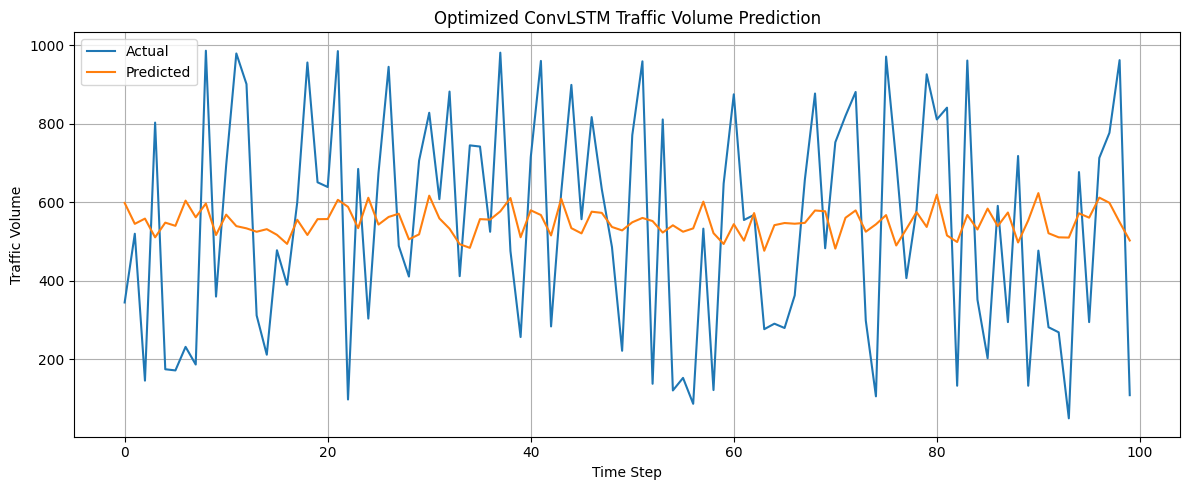

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted')
plt.title("Optimized ConvLSTM Traffic Volume Prediction")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
print("Last 20 Traffic Volume Predictions vs Actual:")

for i in range(-20, 0):
    actual = y_test_inv[i][0]
    predicted = y_pred_inv[i][0]
    print(f"{len(y_test_inv) + i + 1:4d}) Actual: {actual:.2f}, Predicted: {predicted:.2f}")

Last 20 Traffic Volume Predictions vs Actual:
 377) Actual: 203.00, Predicted: 463.89
 378) Actual: 270.00, Predicted: 437.31
 379) Actual: 356.00, Predicted: 524.98
 380) Actual: 534.00, Predicted: 535.40
 381) Actual: 148.00, Predicted: 524.33
 382) Actual: 568.00, Predicted: 580.38
 383) Actual: 196.00, Predicted: 522.22
 384) Actual: 374.00, Predicted: 537.85
 385) Actual: 532.00, Predicted: 547.38
 386) Actual: 240.00, Predicted: 539.88
 387) Actual: 128.00, Predicted: 551.41
 388) Actual: 719.00, Predicted: 615.29
 389) Actual: 727.00, Predicted: 569.26
 390) Actual: 972.00, Predicted: 537.25
 391) Actual: 72.00, Predicted: 603.62
 392) Actual: 563.00, Predicted: 534.39
 393) Actual: 682.00, Predicted: 626.62
 394) Actual: 667.00, Predicted: 505.59
 395) Actual: 476.00, Predicted: 421.21
 396) Actual: 429.00, Predicted: 437.54


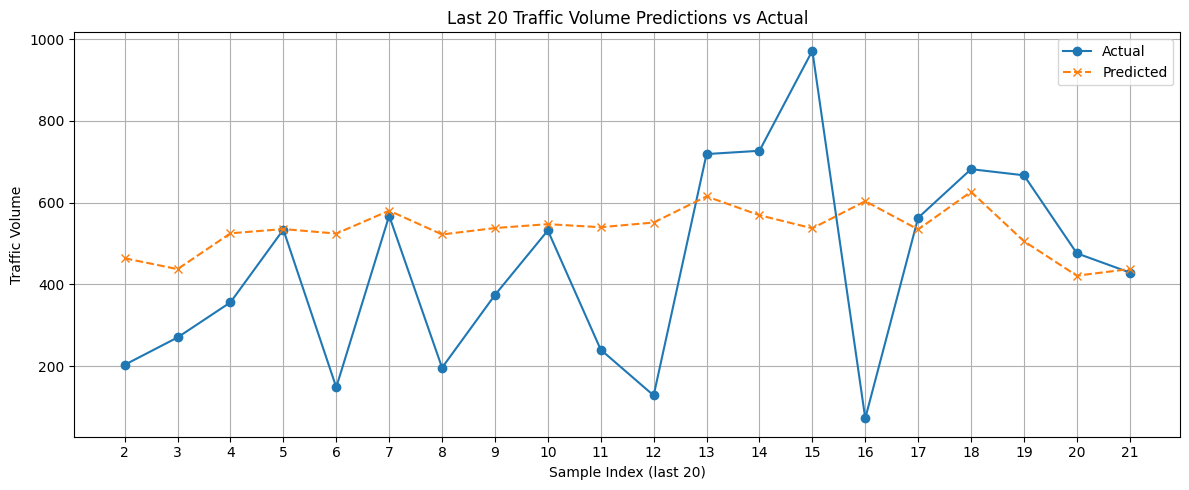

In [10]:
actual_last20 = y_test_inv[-20:].flatten()
predicted_last20 = y_pred_inv[-20:].flatten()

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(actual_last20, label='Actual', marker='o', linestyle='-')
plt.plot(predicted_last20, label='Predicted', marker='x', linestyle='--')
plt.title("Last 20 Traffic Volume Predictions vs Actual")
plt.xlabel("Sample Index (last 20)")
plt.ylabel("Traffic Volume")
plt.xticks(ticks=np.arange(0, 20), labels=[str(i+1) for i in range(1, 21)])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()